In [2]:
import math
from numpy import genfromtxt
import numpy as np
import NOCgraph

In [3]:
my_data = genfromtxt('traffic_uniform.csv', delimiter=',')
#check the shape of the dataframe
my_data.shape[0] == my_data.shape[-1]
#get mesh
mesh = math.sqrt(my_data.shape[-1])

In [4]:
class core(): 
    def __init__(self):
        self.Id = 0
        self.Traffic = None
        self.Position = None
        self.Neighbours = []

def dist(a , b):
    d = (a[0] -b[0])**2 + (a[1] -b[1])**2 
    d = math.sqrt(d)
    d = math.ceil(d)
    return d

def traffic_allocation(tr): # Map traffic for each core 
    d = {} 
    #print(x, y, tr)
    for i in range(64):
        d[str(i)] = tr[i]
    return d
        
# Base design Construction
def design(traffic):
    Core_design = list()
    for i in range(64):
        Core_design.append(core())
        Core_design[i].Traffic = traffic_allocation(traffic[i])
        Core_design[i].Id = i
        
    random_design = Core_design    
    for i in range(8):
        for j in range(8):
            random_design[i*8+j].Position = [i,j]
    random_design = links_connection(random_design)
    while not check_links(random_design):
        random_design = design(traffic)
    return random_design
    

#create random links, length <=4
def valid_neighbour_generator(x,y): 
    neighbours = list()
    for i in range(8):
        for j in range(8):
            d = dist([x,y],[i,j]) 
            if (d>0) and (d<=4):
                neighbours.append([i,j])
    return neighbours

def links_connection(design):
    links  = 0
    visited = list()
    i = np.random.choice(range(64))
    while (links < 112):
        if i not in visited:
            visited.append(i)
        else:
            while i in visited:
                i = np.random.choice(range(64))
        if len(visited)> 60:
            visited = []
        links = link_per_core(design,i,links)
    
    return design

def link_per_core(design,position,links):  # links are connected for each core and constrained has been maintained as total links112
    link_count  = 7
    p_x,p_y  =  design[position].Position
    valid_neighbours = valid_neighbour_generator(p_x, p_y)
    np.random.shuffle(valid_neighbours)
    ind =0
    while True:
        if len(design[position].Neighbours)>= link_count:
            return links
        x,y = valid_neighbours[ind]
        c  = core_location(design,[x,y])
        if (len(c.Neighbours)< link_count):
            if ([x,y] not in design[position].Neighbours) and ([p_x,p_y] not in c.Neighbours):
                if links < 112:
                    d= dist([p_x,p_y], [x,y])
                    if d<4:
                        design[position].Neighbours.append([x,y])
                        c.Neighbours.append([p_x,p_y])
                        links+=1
                else:
                    return links 
        if np.random.choice([0,1]):  # randomization added for links.
                return links
        ind = ind+ 1
        if ind >=  len(valid_neighbours):
            return links
    
def check_links(design):
    for i in range(64):   
            if len(design[i].Neighbours) == 0:
                return 0
            if len(design[i].Neighbours) > 7:
                return 0
    return 1

def core_location(design , v_pos):
    for i in design:
        if i.Position == v_pos:
            return i
    print("Unknown core")

In [5]:
#function plot NOC graph
import matplotlib.pyplot as plt

def display_NOC(design):
    for i in range(8):
        for j in range(8):
            #plot core placements
            plt.plot(i,j ,'x')
            #plot links
            for k in design[i*8+j].Neighbours:
                plt.plot([k[0],design[i*8+j].Position[0]],[k[1],design[i*8+j].Position[1]],'o-') 
    plt.grid()
    plt.show()

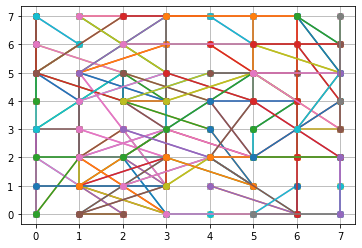

In [6]:
new_design = design(my_data)
display_NOC(new_design)

In [7]:
#link placement: adjacency matrix & task placement: vector for task placement 
def task_placement(design):
    core_matrix = np.zeros((64))
    for i in range(64):
        core_matrix[design[i].Id] = int(design[i].Position[0]*8+design[i].Position[1])
    core_matrix = core_matrix.reshape(1,64)    
    return core_matrix
       
def link_placement(design):
    core_links = np.zeros((64,64))
    for i in range(64):
         core_links[i] = adjacency(design[i])
    #core_links = core_links.reshape(1,4096)        
    return core_links

def adjacency(c):
    line=np.zeros(64)
    for n in c.Neighbours:
        adj = n[0]*8 +n[1]
        line[adj] = 1
    return line

In [8]:
#dijkstra shortest path algorithm
import queue  

def dijkstra(graph, source, dest):  
    q = queue.PriorityQueue()
    parents = []
    distances = []
    start_weight = float("inf")

    for i in graph.get_vertex():
        weight = start_weight
        if source == i:
            weight = 0
        distances.append(weight)
        parents.append(None)

    q.put(([0, source]))

    while not q.empty():
        v_tuple = q.get()
        v = v_tuple[1]

        for e in graph.get_edge(v):
            candidate_distance = distances[v] + e.weight
            if distances[e.vertex] > candidate_distance:
                distances[e.vertex] = candidate_distance
                parents[e.vertex] = v
                # primitive but effective negative cycle detection
                if candidate_distance < -1000:
                    raise Exception("Negative cycle detected")
                q.put(([distances[e.vertex], e.vertex]))

    shortest_path = []
    end = dest
    while end is not None:
        shortest_path.append(end)
        end = parents[end]

    shortest_path.reverse()
    if len(shortest_path)-1 == 0:
        return 'invalid'
    return len(shortest_path)-1
   

In [11]:
def cost_per_core(design,graph,s):
    hop_count=0
    traffic_wtd_count = 0
    for de in range(64):
        src_id = design[s].Id
        d_id =  design[de].Id
        if s != de:
            hop_count = dijkstra(graph,src_id,d_id)
            if hop_count == 'invalid':
                return 'invalid'
            else:
                traffic = design[s].Traffic[str(d_id)]
                traffic_wtd_count += (hop_count * traffic)
    return traffic_wtd_count

def get_cost(design,wt_graph):
    cost = 0
    for cores in range(64):
        weight = cost_per_core(design,wt_graph,cores)
        if weight == 'invalid':
            print('Not a valid design')
            return 'invalid'
        else:
            cost+= weight
    return cost

In [14]:
import copy

def cores_swap(curr,nxt):
    curr.Position,nxt.Position = nxt.Position,curr.Position
    curr.Neighbours,nxt.Neighbours = nxt.Neighbours,curr.Neighbours

def change_core(design):
    curr =  design[np.random.choice(range(64))]
    nxt = design[np.random.choice(range(64))]
    cores_swap(curr,nxt)
    return design

def random_change(d):
    design = copy.deepcopy(d)
    if np.random.choice([1,0]):
        design = change_core(design)
    else:
        design = change_link(design)
    if not check_links(design):
        design = d
    return design

def change_link(design):
    x = np.random.choice(range(64))
    curr = design[x]
    v_neighbours  = valid_neighbour_generator(curr.Position[0],curr.Position[1])
    link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    n = core_location(design,link) 
    while (link in curr.Neighbours) and len(n.Neighbours) == 7 :
        link  = v_neighbours[np.random.choice(range(len(v_neighbours)))]
    curr.Neighbours = curr.Neighbours[:-1]
    curr.Neighbours.append(link)
    n.Neighbours.append(curr.Position)
    return design

In [37]:
#regression algorithm : RandomForestRegressor 
from sklearn.ensemble import RandomForestRegressor

def stage(data):
    curr_state = design(data)
    stateset = []
    costs = []
    numiter =0
    while numiter< 20:
        curr_state,stateset,costs = hill_climbing_1(stateset , costs , curr_state)     
        random_regr = RandomForestRegressor(max_depth=10, random_state=20,n_estimators=100)
        random_regr.fit(np.array(stateset),np.array(costs))
        curr_state = hill_climbing_2(design(data),random_regr)
        numiter+=1
    return curr_state,costs

def hill_climbing_1(states, costs, current):
    graph_current =NOCgraph.create_graph(current)
    cost_current = get_cost(current, graph_current)
    T = 0
    while T<50:
        nxt = random_change(current)
        g_nxt = NOCgraph.create_graph(nxt)
        cost_nxt = get_cost(nxt,g_nxt)
        if cost_nxt != 'invalid':
            if cost_nxt< cost_current:
                l_map = task_placement(nxt)
                adj_matrix = link_placement(nxt)
                line = np.append(l_map, adj_matrix)
                costs.append(cost_nxt)
                states.append(line)
        T +=1
    return current,states,costs

def hill_climbing_2(current, regres):
    currentnode = current
    c_place = task_placement(current)
    adj_matrix = link_placement(current)
    line = np.append(c_place, adj_matrix)
    line = line.reshape(1,4160)
    current_cost = regres.predict(line)
    t = 0
    while t<5000:
        nxt = random_change(current)
        c_place = task_placement(nxt)
        adj_matrix = link_placement(nxt)
        line = np.append(c_place, adj_matrix)
        line = line.reshape(1,4160)
        nxt_cost = regres.predict(line)
        if nxt_cost< current_cost:
            current_cost = nxt_cost
            current = nxt
        t +=1
    return current

In [18]:

B_state , d = stage(my_data)
#curr_state = design(my_data)
#curr_state,D1,D2 = hill_climbing_1(d_dataset , d_costs , curr_state,D1,D2)
#D1
#random_regr = RandomForestRegressor(max_depth=10, random_state=20,n_estimators=100)
#random_regr.fit(np.array(D1),np.array(D2))


In [24]:
B_state1 , b1 = stage(my_data)

In [25]:
B_graph1 = NOCgraph.create_graph(B_state1)
get_cost(B_state,B_graph1)

5381.2206746005995

In [26]:
#load file traffic_random
traffic_rand = genfromtxt('traffic_rand.csv', delimiter=',')

In [27]:
r_state , r1 = stage(traffic_rand)

In [29]:
r_graph1 = NOCgraph.create_graph(r_state)
get_cost(r_state,r_graph1)

6952.626385156203

In [ ]:
t_rand[0]

In [31]:
#load file traffic_complement
traffic_comp = genfromtxt('traffic_complement.csv', delimiter=',')

In [32]:
c_state , c1 = stage(traffic_comp)

In [34]:
c_graph = NOCgraph.create_graph(c_state)
get_cost(c_state,c_graph)

1399.978043621716

In [38]:
B_state2 , b2 = stage(my_data)

In [39]:
B_graph2 = NOCgraph.create_graph(B_state2)
get_cost(B_state,B_graph2)

4701.621801904169

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

def stage1(data):
    curr_state = design(data)
    stateset = []
    costs = []
    count =0
    while count< 20:
        curr_state,stateset,costs = hill_climbing_1(stateset , costs , curr_state)     
        linear_regr = LinearRegression()
        linear_regr.fit(np.array(stateset),np.array(costs))
        curr_state = hill_climbing_2(design(data),linear_regr)
        count+=1
    return curr_state,costs

In [49]:
b1_state_stack , b1_stack = stage1(my_data)

In [50]:
b1_stack_graph = NOCgraph.create_graph(b1_state_stack)
get_cost(b1_state_stack,b1_stack_graph)

4005.5494987918637

In [58]:
t_b1 = task_placement(b1_state_stack)
l_b1 = link_placement(b1_state_stack)
import pandas
l_b1_adj = pandas.DataFrame(l_b1,columns=t_b1[0], index=t_b1[0])
l_b1_adj

,12.0,33.0,59.0,39.0,4.0,6.0,56.0,3.0,24.0,62.0,...,36.0,43.0,16.0,14.0,32.0,54.0,18.0,40.0,34.0,47.0
12.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
t_b1

array([[12., 33., 59., 39.,  4.,  6., 56.,  3., 24., 62.,  9., 50., 53.,
        38., 60., 45., 17.,  2.,  1., 58., 48.,  8., 15., 37., 57.,  5.,
        52., 19., 61., 10., 30., 20., 23., 26.,  7., 27., 55., 25., 28.,
        46., 11., 35., 21., 31., 44., 22., 42., 63., 29., 49., 13., 51.,
         0., 41., 36., 43., 16., 14., 32., 54., 18., 40., 34., 47.]])

In [55]:
r1_state_stack , r1_stack = stage1(traffic_rand)

In [56]:
r1_stack_graph = NOCgraph.create_graph(r1_state_stack)
get_cost(r1_state_stack,r1_stack_graph)

5279.470931016056

In [62]:
t_r1 = task_placement(r1_state_stack)
l_r1 = link_placement(r1_state_stack)
import pandas
l_r1_adj = pandas.DataFrame(l_r1,columns=t_r1[0], index=t_r1[0])
l_r1_adj

,55.0,40.0,7.0,47.0,10.0,53.0,31.0,23.0,61.0,56.0,...,0.0,8.0,25.0,3.0,41.0,43.0,39.0,21.0,5.0,14.0
55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
10.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
39.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
t_r1[0]

array([55., 40.,  7., 47., 10., 53., 31., 23., 61., 56., 49., 62., 48.,
       26., 32., 58., 57., 34., 59., 19., 22., 29., 46., 36., 38., 15.,
        1.,  9., 51., 52., 30., 63., 16., 54., 18., 33., 28., 60., 35.,
       13., 20., 12.,  2.,  6., 44., 27., 45., 17., 24., 42., 37., 11.,
       50.,  4.,  0.,  8., 25.,  3., 41., 43., 39., 21.,  5., 14.])

In [71]:
t_c1 = task_placement(c_state)
l_c1 = link_placement(c_state)
import pandas
l_c1_adj = pandas.DataFrame(l_c1,columns=t_c1[0], index=t_c1[0])
l_c1_adj

,34.0,17.0,45.0,55.0,37.0,52.0,6.0,8.0,12.0,44.0,...,42.0,47.0,15.0,39.0,25.0,7.0,26.0,61.0,22.0,63.0
34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
55.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
61.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
t_c1[0]

array([34., 17., 45., 55., 37., 52.,  6.,  8., 12., 44., 10., 23., 35.,
       38., 14., 21., 24., 62., 60., 58., 20., 46., 57., 40., 53., 11.,
       48., 56., 28., 18., 13., 31., 19.,  5.,  3., 30., 36., 59., 54.,
        4., 16., 33., 27.,  2., 32., 51.,  9.,  1., 50., 29., 43., 41.,
        0., 49., 42., 47., 15., 39., 25.,  7., 26., 61., 22., 63.])